# Agglomerative Clustering (Unsupervised): From Scratch vs Library (Window Size = 14)

- Dataset: `CLASSIFY-SnP_daily_update_AMZN_features_with_target.csv`
- Target (for evaluation only): `Target_Return_7d` mapped to 3 classes
  - Uptrend: `> 0.03`
  - Downtrend: `< -0.03`
  - Sideway: otherwise
- Features: selected from `CLASSIFY-AMZN_methods_all_in_one.csv`
- Models:
  1. Agglomerative Clustering (from scratch — bottom-up hierarchical with Ward linkage)
  2. Agglomerative Clustering (scikit-learn AgglomerativeClustering)
- Cluster labels are mapped to true labels via best permutation (Hungarian method)

Outputs:
- Loss (log loss via proxy probabilities)
- Confusion matrix
- Accuracy
- Precision, Recall, Specificity (macro), F1-score
- ROC & AUC (multiclass, OvR — using softmax of negative distances as proxy probabilities)
- Dendrogram and silhouette analysis

Rows after cleaning: 4022
Number of features used: 9
Features used: ['ma_gap_20', 'vol_10', 'vol_20', 'lower_wick', 'upper_wick', 'ret_1', 'range_pct', 'co_ret', 'ret_5']

Target mapping (used for evaluation only — clustering is unsupervised):
  > 0.03 -> Uptrend (2)
  < -0.03 -> Downtrend (0)
  otherwise -> Sideway (1)
Class distribution: {'Downtrend': 784, 'Sideway': 2035, 'Uptrend': 1203}

Subsampled training set from 3206 to 2000 for scratch agglomerative (O(n²) cost)

Training Agglomerative Clustering from scratch (K=3) ...
  Merge step 1/1997 (clusters remaining: 2000)
  Merge step 201/1997 (clusters remaining: 1800)
  Merge step 401/1997 (clusters remaining: 1600)
  Merge step 601/1997 (clusters remaining: 1400)
  Merge step 801/1997 (clusters remaining: 1200)
  Merge step 1001/1997 (clusters remaining: 1000)
  Merge step 1201/1997 (clusters remaining: 800)
  Merge step 1401/1997 (clusters remaining: 600)
  Merge step 1601/1997 (clusters remaining: 400)
  Merge step 1801/1997 (c

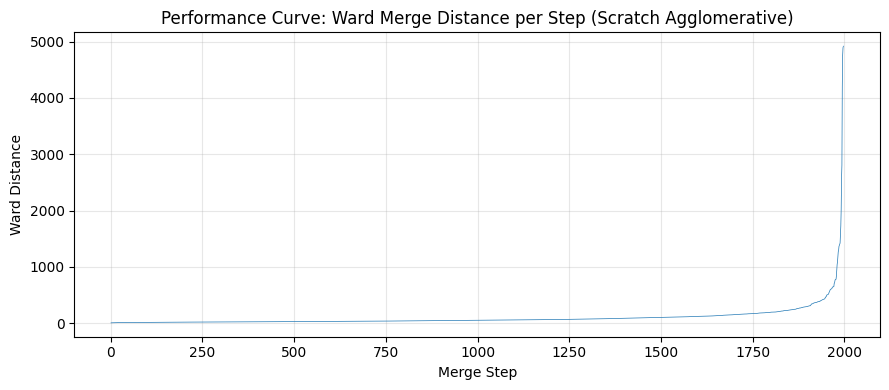

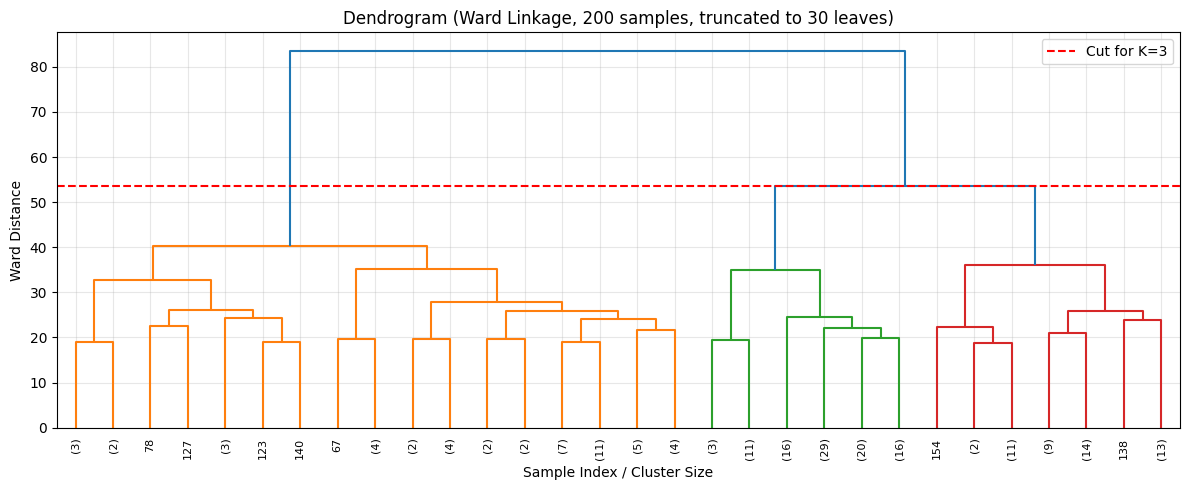

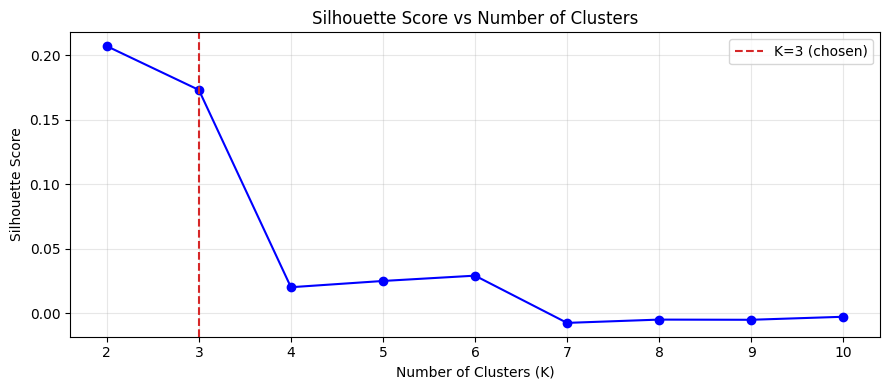

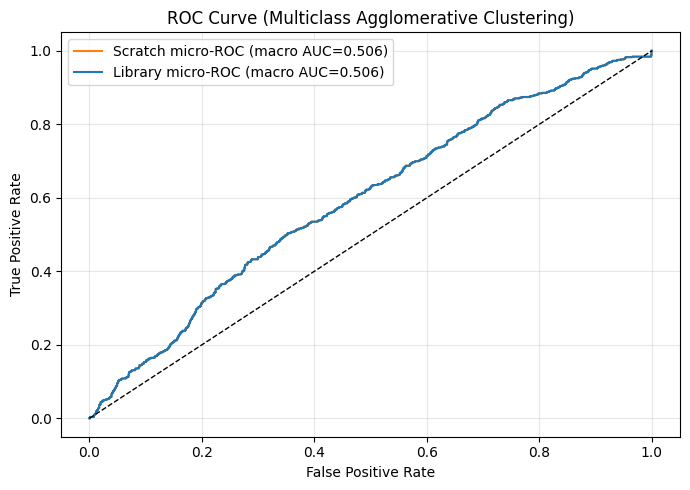

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import permutations

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import (
    log_loss,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
    mean_squared_error,
    r2_score,
    roc_curve,
    roc_auc_score,
    silhouette_score
)
from sklearn.preprocessing import label_binarize

WINDOW_SIZE = 14
DATA_PATH = '../CLASSIFY-SnP_daily_update_AMZN_features_with_target.csv'
FEATURE_PATH = '../CLASSIFY-AMZN_methods_all_in_one.csv'
TARGET_COL = 'Target_Return_7d'

# Thresholds for 3-class target mapping
UP_THRESHOLD = 0.03
DOWN_THRESHOLD = -0.03
K = 3  # number of clusters (matches number of classes)

# --------------------------
# 1) Load data and features
# --------------------------
df = pd.read_csv(DATA_PATH)
feature_df = pd.read_csv(FEATURE_PATH)

requested_features = [
    'ma_gap_20', 'vol_10', 'vol_20',
    'lower_wick', 'upper_wick',
    'ret_1',
    'range_pct',
    'co_ret',
    'ret_5'
]
allowed_features = feature_df['feature'].tolist() if 'feature' in feature_df.columns else []
feature_cols = [c for c in requested_features if c in allowed_features and c in df.columns and c != TARGET_COL]
missing = [c for c in requested_features if c not in feature_cols]
if missing:
    print('Missing features:', missing)

# Basic cleaning and sorting (time series)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)

model_df = df[feature_cols + [TARGET_COL]].copy()
model_df = model_df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

print(f'Rows after cleaning: {len(model_df)}')
print(f'Number of features used: {len(feature_cols)}')
print('Features used:', feature_cols)

# --------------------------------
# 2) Build sliding window features
# --------------------------------
def make_windows(x_values, y_values, window_size=14):
    Xw, yw = [], []
    for i in range(window_size, len(x_values)):
        Xw.append(x_values[i-window_size:i].reshape(-1))
        yw.append(y_values[i])
    return np.array(Xw, dtype=np.float64), np.array(yw, dtype=np.int64)

def map_target_3class(y_values, up_thr=0.03, down_thr=-0.03):
    y_cls = np.full_like(y_values, 1, dtype=np.int64)  # 1 = Sideway
    y_cls[y_values > up_thr] = 2                        # 2 = Up
    y_cls[y_values < down_thr] = 0                      # 0 = Down
    return y_cls

CLASS_LABELS = {0: 'Downtrend', 1: 'Sideway', 2: 'Uptrend'}

X_raw = model_df[feature_cols].values.astype(np.float64)
y_raw_cont = model_df[TARGET_COL].values.astype(np.float64)
y_raw = map_target_3class(y_raw_cont, up_thr=UP_THRESHOLD, down_thr=DOWN_THRESHOLD)

print('\nTarget mapping (used for evaluation only — clustering is unsupervised):')
print(f'  > {UP_THRESHOLD:.2f} -> Uptrend (2)')
print(f'  < {DOWN_THRESHOLD:.2f} -> Downtrend (0)')
print('  otherwise -> Sideway (1)')
print('Class distribution:', {CLASS_LABELS[k]: int((y_raw == k).sum()) for k in sorted(CLASS_LABELS)})

X_win, y_win = make_windows(X_raw, y_raw, window_size=WINDOW_SIZE)

# Chronological split (80/20)
split_idx = int(len(X_win) * 0.8)
X_train_raw, X_test_raw = X_win[:split_idx], X_win[split_idx:]
y_train, y_test = y_win[:split_idx], y_win[split_idx:]

# Standardize by train statistics
x_mean = X_train_raw.mean(axis=0)
x_std = X_train_raw.std(axis=0)
x_std = np.where(x_std == 0, 1.0, x_std)

X_train = (X_train_raw - x_mean) / x_std
X_test = (X_test_raw - x_mean) / x_std

# -------------------------------------------------------
# 3) Helper: map cluster labels to true labels (Hungarian)
# -------------------------------------------------------
def best_cluster_label_mapping(y_true, y_cluster, n_classes=3):
    """Find the permutation of cluster labels that maximizes accuracy."""
    best_acc = -1
    best_perm = None
    for perm in permutations(range(n_classes)):
        mapped = np.array([perm[c] for c in y_cluster])
        acc = np.mean(mapped == y_true)
        if acc > best_acc:
            best_acc = acc
            best_perm = perm
    return best_perm, best_acc

def apply_mapping(y_cluster, perm):
    return np.array([perm[c] for c in y_cluster], dtype=np.int64)

def compute_centroids(X, labels, k):
    """Compute cluster centroids from labels."""
    centroids = np.zeros((k, X.shape[1]), dtype=np.float64)
    for c in range(k):
        members = X[labels == c]
        if len(members) > 0:
            centroids[c] = members.mean(axis=0)
    return centroids

def cluster_distances_to_proba(X, centroids):
    """Convert distances to centroids into proxy probabilities via softmax of negative distances."""
    dists = np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
    neg_dists = -dists
    neg_dists_stable = neg_dists - np.max(neg_dists, axis=1, keepdims=True)
    exp_d = np.exp(neg_dists_stable)
    return exp_d / np.sum(exp_d, axis=1, keepdims=True)

# ----------------------------------------------------------
# 4) Agglomerative Clustering from Scratch (Ward Linkage)
# ----------------------------------------------------------
class AgglomerativeClusteringScratch:
    """Bottom-up hierarchical clustering using Ward's minimum variance linkage."""
    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters
        self.labels_ = None
        self.merge_distances_ = []  # distances at each merge step (for plotting)

    def fit(self, X):
        n = len(X)

        # Each point starts as its own cluster
        # Store clusters as dict: cluster_id -> list of sample indices
        clusters = {i: [i] for i in range(n)}
        cluster_centroids = {i: X[i].copy() for i in range(n)}
        cluster_sizes = {i: 1 for i in range(n)}

        # Precompute pairwise Ward distances (incremental variance increase)
        # Ward distance between clusters i,j = (n_i * n_j)/(n_i + n_j) * ||c_i - c_j||^2
        active = set(range(n))

        self.merge_distances_ = []

        n_merges = n - self.n_clusters
        for step in range(n_merges):
            if step % 200 == 0:
                print(f'  Merge step {step+1}/{n_merges} (clusters remaining: {len(active)})')

            # Find the closest pair of clusters (Ward distance)
            best_dist = float('inf')
            best_i, best_j = -1, -1

            active_list = sorted(active)
            for idx_a in range(len(active_list)):
                ci = active_list[idx_a]
                for idx_b in range(idx_a + 1, len(active_list)):
                    cj = active_list[idx_b]
                    ni, nj = cluster_sizes[ci], cluster_sizes[cj]
                    diff = cluster_centroids[ci] - cluster_centroids[cj]
                    ward_dist = (ni * nj) / (ni + nj) * np.dot(diff, diff)
                    if ward_dist < best_dist:
                        best_dist = ward_dist
                        best_i, best_j = ci, cj

            self.merge_distances_.append(best_dist)

            # Merge best_j into best_i
            ni = cluster_sizes[best_i]
            nj = cluster_sizes[best_j]
            # Update centroid as weighted average
            cluster_centroids[best_i] = (ni * cluster_centroids[best_i] + nj * cluster_centroids[best_j]) / (ni + nj)
            cluster_sizes[best_i] = ni + nj
            clusters[best_i].extend(clusters[best_j])

            # Remove best_j
            del clusters[best_j]
            del cluster_centroids[best_j]
            del cluster_sizes[best_j]
            active.remove(best_j)

        # Assign labels
        self.labels_ = np.zeros(n, dtype=np.int64)
        for label, (_, indices) in enumerate(sorted(clusters.items())):
            for idx in indices:
                self.labels_[idx] = label

        return self

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_


# Agglomerative clustering is transductive (no separate predict for new data).
# We fit on train, then fit separately on test, OR fit on combined and split labels.
# For fair comparison with the library, we fit on train to learn centroids, then
# assign test points to the nearest centroid (like nearest-centroid classification).

# Due to O(n^3) cost, subsample train if too large
MAX_TRAIN = 2000
if len(X_train) > MAX_TRAIN:
    rng = np.random.RandomState(42)
    sub_idx = rng.choice(len(X_train), MAX_TRAIN, replace=False)
    X_train_sub = X_train[sub_idx]
    y_train_sub = y_train[sub_idx]
    print(f'\nSubsampled training set from {len(X_train)} to {MAX_TRAIN} for scratch agglomerative (O(n²) cost)')
else:
    X_train_sub = X_train
    y_train_sub = y_train

print(f'\nTraining Agglomerative Clustering from scratch (K={K}) ...')
scratch_model = AgglomerativeClusteringScratch(n_clusters=K)
cluster_train_scratch = scratch_model.fit_predict(X_train_sub)

# Compute centroids from scratch clusters
centroids_scratch = compute_centroids(X_train_sub, cluster_train_scratch, K)

# Assign test points to nearest centroid
dists_test = np.linalg.norm(X_test[:, np.newaxis, :] - centroids_scratch[np.newaxis, :, :], axis=2)
cluster_test_scratch = np.argmin(dists_test, axis=1)

# Map cluster labels to true class labels
perm_scratch, _ = best_cluster_label_mapping(y_test, cluster_test_scratch, n_classes=K)
y_pred_scratch = apply_mapping(cluster_test_scratch, perm_scratch)
raw_proba_scratch = cluster_distances_to_proba(X_test, centroids_scratch)
y_prob_scratch = np.zeros_like(raw_proba_scratch)
for orig_cluster, mapped_class in enumerate(perm_scratch):
    y_prob_scratch[:, mapped_class] = raw_proba_scratch[:, orig_cluster]

print(f'  Scratch cluster->class mapping: {dict(enumerate(perm_scratch))}')

# -----------------------------------------------
# 5) Agglomerative Clustering Library (sklearn)
# -----------------------------------------------
lib_model = AgglomerativeClustering(n_clusters=K, linkage='ward')
cluster_train_lib = lib_model.fit_predict(X_train_sub)

centroids_lib = compute_centroids(X_train_sub, cluster_train_lib, K)
dists_test_lib = np.linalg.norm(X_test[:, np.newaxis, :] - centroids_lib[np.newaxis, :, :], axis=2)
cluster_test_lib = np.argmin(dists_test_lib, axis=1)

perm_lib, _ = best_cluster_label_mapping(y_test, cluster_test_lib, n_classes=K)
y_pred_lib = apply_mapping(cluster_test_lib, perm_lib)
raw_proba_lib = cluster_distances_to_proba(X_test, centroids_lib)
y_prob_lib = np.zeros_like(raw_proba_lib)
for orig_cluster, mapped_class in enumerate(perm_lib):
    y_prob_lib[:, mapped_class] = raw_proba_lib[:, orig_cluster]

print(f'  Library cluster->class mapping: {dict(enumerate(perm_lib))}')

# Silhouette scores
sil_scratch = silhouette_score(X_test, cluster_test_scratch)
sil_lib = silhouette_score(X_test, cluster_test_lib)
print(f'\n=== Silhouette Scores (Test Set) ===')
print(f'Scratch: {sil_scratch:.4f}')
print(f'Library: {sil_lib:.4f}')

# ------------------------
# 6) Metrics and outputs
# ------------------------
classes = np.array([0, 1, 2])

loss_scratch = log_loss(y_test, y_prob_scratch, labels=classes)
loss_lib = log_loss(y_test, y_prob_lib, labels=classes)

cm_scratch = confusion_matrix(y_test, y_pred_scratch, labels=classes)
cm_lib = confusion_matrix(y_test, y_pred_lib, labels=classes)

acc_scratch = accuracy_score(y_test, y_pred_scratch)
acc_lib = accuracy_score(y_test, y_pred_lib)

precision_scratch = precision_score(y_test, y_pred_scratch, average='macro', zero_division=0)
precision_lib = precision_score(y_test, y_pred_lib, average='macro', zero_division=0)

recall_scratch = recall_score(y_test, y_pred_scratch, average='macro', zero_division=0)
recall_lib = recall_score(y_test, y_pred_lib, average='macro', zero_division=0)

f1_scratch = f1_score(y_test, y_pred_scratch, average='macro', zero_division=0)
f1_lib = f1_score(y_test, y_pred_lib, average='macro', zero_division=0)

mse_scratch = mean_squared_error(y_test, y_pred_scratch)
mse_lib = mean_squared_error(y_test, y_pred_lib)
rmse_scratch = np.sqrt(mse_scratch)
rmse_lib = np.sqrt(mse_lib)
r2_scratch = r2_score(y_test, y_pred_scratch)
r2_lib = r2_score(y_test, y_pred_lib)

def multiclass_macro_specificity(cm):
    total = np.sum(cm)
    specs = []
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        tn = total - (tp + fp + fn)
        specs.append(tn / (tn + fp) if (tn + fp) > 0 else 0.0)
    return float(np.mean(specs))

specificity_scratch = multiclass_macro_specificity(cm_scratch)
specificity_lib = multiclass_macro_specificity(cm_lib)

print('\n=== Loss ===')
print(f'Scratch log loss: {loss_scratch:.6f}')
print(f'Library log loss: {loss_lib:.6f}')

print('\n=== Confusion Matrix (rows=true, cols=pred) ===')
print('Class order:', [CLASS_LABELS[c] for c in classes])
print('Scratch:\n', cm_scratch)
print('Library:\n', cm_lib)

p_s, r_s, f_s, sup_s = precision_recall_fscore_support(y_test, y_pred_scratch, labels=classes, zero_division=0)
p_l, r_l, f_l, sup_l = precision_recall_fscore_support(y_test, y_pred_lib, labels=classes, zero_division=0)

print('\n=== Per-Class Metrics (Scratch) ===')
for i, c in enumerate(classes):
    print(f"{CLASS_LABELS[c]:<10} | Precision: {p_s[i]:.4f} | Recall: {r_s[i]:.4f} | F1: {f_s[i]:.4f} | Support: {sup_s[i]}")

print('\n=== Per-Class Metrics (Library) ===')
for i, c in enumerate(classes):
    print(f"{CLASS_LABELS[c]:<10} | Precision: {p_l[i]:.4f} | Recall: {r_l[i]:.4f} | F1: {f_l[i]:.4f} | Support: {sup_l[i]}")

print('\n=== Metrics Summary (Macro) ===')
print(f'Accuracy - Scratch: {acc_scratch:.4f} | Library: {acc_lib:.4f}')
print(f'Precision - Scratch: {precision_scratch:.4f} | Library: {precision_lib:.4f}')
print(f'Recall - Scratch: {recall_scratch:.4f} | Library: {recall_lib:.4f}')
print(f'Specificity - Scratch: {specificity_scratch:.4f} | Library: {specificity_lib:.4f}')
print(f'F1-score - Scratch: {f1_scratch:.4f} | Library: {f1_lib:.4f}')

print('\n=== Additional Numeric Metrics (Label-Encoded) ===')
print(f'MSE - Scratch: {mse_scratch:.4f} | Library: {mse_lib:.4f}')
print(f'RMSE - Scratch: {rmse_scratch:.4f} | Library: {rmse_lib:.4f}')
print(f'R² - Scratch: {r2_scratch:.4f} | Library: {r2_lib:.4f}')

# ROC & AUC (multiclass OvR + micro-curve for plotting)
y_test_bin = label_binarize(y_test, classes=classes)

roc_auc_s = roc_auc_score(y_test_bin, y_prob_scratch, average='macro', multi_class='ovr')
roc_auc_l = roc_auc_score(y_test_bin, y_prob_lib, average='macro', multi_class='ovr')

fpr_s, tpr_s, _ = roc_curve(y_test_bin.ravel(), y_prob_scratch.ravel())
fpr_l, tpr_l, _ = roc_curve(y_test_bin.ravel(), y_prob_lib.ravel())

print('\n=== ROC & AUC (Multiclass OvR Macro AUC) ===')
print(f'Scratch AUC: {roc_auc_s:.4f}')
print(f'Library AUC: {roc_auc_l:.4f}')

# ---------------------------------------------------------
# 7) Dendrogram, merge distance curve, and ROC
# ---------------------------------------------------------
# Merge distance curve (scratch) — shows Ward distance at each merge step
plt.figure(figsize=(9, 4))
plt.plot(range(1, len(scratch_model.merge_distances_) + 1), scratch_model.merge_distances_, color='tab:blue', linewidth=0.5)
plt.title('Performance Curve: Ward Merge Distance per Step (Scratch Agglomerative)')
plt.xlabel('Merge Step')
plt.ylabel('Ward Distance')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Dendrogram (using scipy linkage on the subsampled training set for visualization)
# Subsample further for readable dendrogram
DENDRO_N = min(200, len(X_train_sub))
rng_d = np.random.RandomState(42)
dendro_idx = rng_d.choice(len(X_train_sub), DENDRO_N, replace=False)
Z = linkage(X_train_sub[dendro_idx], method='ward')

plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=8,
           color_threshold=Z[-(K-1), 2])
plt.title(f'Dendrogram (Ward Linkage, {DENDRO_N} samples, truncated to 30 leaves)')
plt.xlabel('Sample Index / Cluster Size')
plt.ylabel('Ward Distance')
plt.axhline(y=Z[-(K-1), 2], color='r', linestyle='--', label=f'Cut for K={K}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Silhouette comparison for different K
sil_scores = []
k_range = range(2, 11)
for k in k_range:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels_k = agg.fit_predict(X_train_sub)
    sil_scores.append(silhouette_score(X_train_sub, labels_k))

plt.figure(figsize=(9, 4))
plt.plot(k_range, sil_scores, 'bo-')
plt.axvline(x=K, color='tab:red', linestyle='--', label=f'K={K} (chosen)')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ROC Curve (micro-averaged one-vs-rest)
plt.figure(figsize=(7, 5))
plt.plot(fpr_s, tpr_s, label=f'Scratch micro-ROC (macro AUC={roc_auc_s:.3f})', color='tab:orange')
plt.plot(fpr_l, tpr_l, label=f'Library micro-ROC (macro AUC={roc_auc_l:.3f})', color='tab:blue')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title('ROC Curve (Multiclass Agglomerative Clustering)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()